# Capstone Week 4 - Adaptive Model Selection → GP

## Strategy Evolution: Testing Multiple Model Types

**Week 3 Baseline:**
- Sequential approach with model selection
- Various models tested
- Submission based on data-driven selection

**Week 4 Innovation:**
- Test **5 different models** via cross-validation:
  1. Linear SVM (baseline)
  2. Decision Tree (simple non-linear)
  3. Random Forest (ensemble)
  4. Logistic Regression (probabilistic)
  5. Neural Network (deep learning)
- **Adaptive Selection:** Automatically pick best performer
- **Goal:** Improve CV and find optimal point
- Sequential BEST MODEL → GP flow

**Why Multiple Models?**
1. Different models excel at different patterns
2. Sufficient samples for model comparison
3. Data-driven selection beats assumptions
4. Expected improvement with right model


In [29]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# TensorFlow for Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

sns.set_style('whitegrid')
print('='*80)
print('WEEK 4: ADAPTIVE MODEL SELECTION → GP')
print('='*80)

WEEK 4: ADAPTIVE MODEL SELECTION → GP


## Load Week 4 Data

In [30]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data - works for ANY function
X = np.load('f2_w4_inputs.npy')
Y = np.load('f2_w4_outputs.npy')

# DYNAMIC VARIABLES - automatically detected from data
n_samples = len(X)
n_dims = X.shape[1]
n_w3 = n_samples - 1  # All samples except the newest
w4_idx = n_samples - 1  # Last sample is W4 new point

print('='*80)
print(f'WEEK 4: RESULTS ANALYSIS')
print('='*80)

print(f'\nData: {n_samples} samples, {n_dims}D')
print(f'n/p ratio: {n_samples/n_dims:.2f}')

print(f'\nY statistics:')
print(f'  Range: {Y.min():.4f} to {Y.max():.4f}')
print(f'  Mean: {Y.mean():.4f} ± {Y.std():.4f}')

# Best point overall
best_idx = np.argmax(Y)
best_pt = X[best_idx]
best_val = Y[best_idx]

print(f'\nBest point (overall):')
print(f'  Index: {best_idx}')
print(f'  Value: {best_val:.6f}')
print(f'  Location: {best_pt}')

# Check boundary pattern
boundary_dims = [i for i, val in enumerate(best_pt) if val < 0.1 or val > 0.9]
if boundary_dims:
    print(f'  Boundary dimensions: {[f"X{i+1}" for i in boundary_dims]}')

# ============================================================================
# WEEK 3 vs WEEK 4 COMPARISON (FULLY DYNAMIC)
# ============================================================================

print('\n' + '='*80)
print('WEEK 3 vs WEEK 4 COMPARISON')
print('='*80)

# Week 3 data = all samples except the last one
X_w3 = X[:n_w3]
Y_w3 = Y[:n_w3]

# Week 4 new point = last sample
x_w4_new = X[w4_idx]
y_w4_new = Y[w4_idx]

# Week 3 best
w3_best_idx = np.argmax(Y_w3)
w3_best_val = Y_w3[w3_best_idx]
w3_best_pt = X_w3[w3_best_idx]

print(f'\nWeek 3 Best:')
print(f'  Index: {w3_best_idx}')
print(f'  Value: {w3_best_val:.6f}')
print(f'  Point: {w3_best_pt}')

print(f'\nWeek 4 New Point:')
print(f'  Index: {w4_idx}')
print(f'  Value: {y_w4_new:.6f}')
print(f'  Point: {x_w4_new}')

# Distance from best W3 point
dist_from_w3 = np.linalg.norm(x_w4_new - w3_best_pt)
print(f'\nDistance from W3 best: {dist_from_w3:.4f}')

# ============================================================================
# PERFORMANCE ANALYSIS
# ============================================================================

print('\n' + '='*80)
print('PERFORMANCE ANALYSIS')
print('='*80)

improvement = y_w4_new - w3_best_val
improvement_pct = (improvement / abs(w3_best_val)) * 100 if w3_best_val != 0 else 0

print(f'\nWeek 4 Performance:')
print(f'  W3 Best: {w3_best_val:.6f}')
print(f'  W4 New:  {y_w4_new:.6f}')
print(f'  Change:  {improvement:+.6f} ({improvement_pct:+.2f}%)')

if y_w4_new > w3_best_val:
    print(f'\n  ✓ SUCCESS! Improved by {improvement:.6f}')
    print(f'  → Adaptive model selection WORKED!')
    
    if best_idx == w4_idx:
        print(f'\n  🏆 NEW GLOBAL BEST! W4 point is best overall')
    else:
        print(f'\n  ℹ W4 improved, but best overall is still index {best_idx}')
        print(f'     Best value: {best_val:.6f}')
        
elif abs(improvement) < 0.01:
    print(f'\n  ≈ Similar to W3 best (within 0.01)')
    print(f'  → Found comparable region')
    
else:
    print(f'\n  ✗ Declined by {abs(improvement):.6f}')
    print(f'  → Exploration attempt')
    print(f'  → Week 5: Return to best region (index {w3_best_idx})')

# ============================================================================
# RANKING ANALYSIS
# ============================================================================

print('\n' + '='*80)
print('RANKING ANALYSIS')
print('='*80)

sorted_indices = np.argsort(Y)[::-1]
w4_rank = np.where(sorted_indices == w4_idx)[0][0] + 1

print(f'\nWeek 4 New Point Rank: #{w4_rank} out of {n_samples}')

print(f'\nTop 5 Points:')
print(f'{"Rank":<6} {"Index":<8} {"Value":<12} {"Week":<8}')
print('─'*40)

for rank, idx in enumerate(sorted_indices[:5], 1):
    week = 'W4 NEW' if idx == w4_idx else f'W1-W3'
    marker = '★' if idx == w4_idx else ' '
    print(f'{marker} #{rank:<4} {idx:<8} {Y[idx]:<12.6f} {week:<8}')

percentile = (w4_rank - 1) / n_samples * 100
print(f'\nPercentile: Top {percentile:.1f}%')

if w4_rank == 1:
    print('  🏆 RANK 1! Best point overall')
elif w4_rank <= 3:
    print(f'  ✓ Top 3! Excellent performance')
elif w4_rank <= 10:
    print(f'  ✓ Top 10! Good performance')
elif percentile <= 25:
    print(f'  ✓ Top quartile!')


WEEK 4: RESULTS ANALYSIS

Data: 13 samples, 2D
n/p ratio: 6.50

Y statistics:
  Range: -0.0656 to 0.6112
  Mean: 0.2778 ± 0.2266

Best point (overall):
  Index: 9
  Value: 0.611205
  Location: [0.70263656 0.9265642 ]
  Boundary dimensions: ['X2']

WEEK 3 vs WEEK 4 COMPARISON

Week 3 Best:
  Index: 9
  Value: 0.611205
  Point: [0.70263656 0.9265642 ]

Week 4 New Point:
  Index: 12
  Value: 0.524619
  Point: [0.705607 1.48793 ]

Distance from W3 best: 0.5614

PERFORMANCE ANALYSIS

Week 4 Performance:
  W3 Best: 0.611205
  W4 New:  0.524619
  Change:  -0.086586 (-14.17%)

  ✗ Declined by 0.086586
  → Exploration attempt
  → Week 5: Return to best region (index 9)

RANKING ANALYSIS

Week 4 New Point Rank: #4 out of 13

Top 5 Points:
Rank   Index    Value        Week    
────────────────────────────────────────
  #1    9        0.611205     W1-W3   
  #2    11       0.550085     W1-W3   
  #3    0        0.538996     W1-W3   
★ #4    12       0.524619     W4 NEW  
  #5    1        0.420586 

## Create Binary Classification Labels

In [31]:
# Binary classification: good (1) vs bad (0)
threshold = np.percentile(Y, 70)
y_binary = (Y > threshold).astype(int)

print(f'Classification threshold (70th percentile): {threshold:.4f}')
print(f'Good samples (y=1): {(y_binary==1).sum()}')
print(f'Bad samples (y=0): {(y_binary==0).sum()}')
print(f'Class balance: {(y_binary==1).sum()/len(y_binary):.1%} good')

Classification threshold (70th percentile): 0.4622
Good samples (y=1): 4
Bad samples (y=0): 9
Class balance: 30.8% good


## Model 1: Linear SVM Baseline (Week 4)

In [32]:
# ============================================================================
# BASELINE: LINEAR SVM (WEEK 4)
# ============================================================================

print('\n' + '='*80)
print('BASELINE: LINEAR SVM (WEEK 4)')
print('='*80)

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Train Linear SVM
svm = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm_cv = cross_val_score(svm, X, y_binary, cv=3)

print(f'\nLinear SVM Performance:')
print(f'  CV Scores: {svm_cv}')
print(f'  Mean CV: {svm_cv.mean():.1%} ± {svm_cv.std():.1%}')

# Train on full data to get feature weights
svm.fit(X, y_binary)
svm_weights = svm.coef_[0]

print(f'\nFeature Importance (SVM weights):')
for i, w in enumerate(svm_weights):
    print(f'  X{i+1}: {w:>+7.4f} {"***" if abs(w) > 0.3 else "**" if abs(w) > 0.15 else ""}')

# Identify most important dimensions
svm_importance = np.abs(svm_weights)
svm_ranking = np.argsort(svm_importance)[::-1]

print(f'\nDimension Ranking (by |weight|):')
for i, dim_idx in enumerate(svm_ranking[:5]):
    print(f'  {i+1}. X{dim_idx+1}: {svm_importance[dim_idx]:.4f}')


BASELINE: LINEAR SVM (WEEK 4)

Linear SVM Performance:
  CV Scores: [0.6  0.75 0.75]
  Mean CV: 70.0% ± 7.1%

Feature Importance (SVM weights):
  X1: -0.1041 
  X2: +0.2197 **

Dimension Ranking (by |weight|):
  1. X2: 0.2197
  2. X1: 0.1041


## Model 2: Decision Tree Classifier

In [33]:
print('\n' + '='*80)
print('MODEL 2: DECISION TREE')
print('='*80)

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=42)
tree_cv = cross_val_score(tree, X, y_binary, cv=3)

print(f'\nDecision Tree Performance:')
print(f'  CV Scores: {tree_cv}')
print(f'  Mean CV: {tree_cv.mean():.1%} ± {tree_cv.std():.1%}')

tree.fit(X, y_binary)
tree_importance = tree.feature_importances_

print(f'\nFeature Importance (Decision Tree):')
for i, imp in enumerate(tree_importance):
    print(f'  X{i+1}: {imp:>7.4f} {"***" if imp > 0.3 else "**" if imp > 0.15 else ""}')

tree_ranking = np.argsort(tree_importance)[::-1]

print(f'\nDimension Ranking:')
for i, dim_idx in enumerate(tree_ranking[:5]):
    print(f'  {i+1}. X{dim_idx+1}: {tree_importance[dim_idx]:.4f}')


MODEL 2: DECISION TREE

Decision Tree Performance:
  CV Scores: [0.6  0.75 0.75]
  Mean CV: 70.0% ± 7.1%

Feature Importance (Decision Tree):
  X1:  0.1576 **
  X2:  0.8424 ***

Dimension Ranking:
  1. X2: 0.8424
  2. X1: 0.1576


## Model 3: Random Forest Classifier

In [34]:
print('\n' + '='*80)
print('MODEL 3: RANDOM FOREST')
print('='*80)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42)
rf_cv = cross_val_score(rf, X, y_binary, cv=3)

print(f'\nRandom Forest Performance:')
print(f'  CV Scores: {rf_cv}')
print(f'  Mean CV: {rf_cv.mean():.1%} ± {rf_cv.std():.1%}')

rf.fit(X, y_binary)
rf_importance = rf.feature_importances_

print(f'\nFeature Importance (Random Forest):')
for i, imp in enumerate(rf_importance):
    print(f'  X{i+1}: {imp:>7.4f} {"***" if imp > 0.3 else "**" if imp > 0.15 else ""}')

rf_ranking = np.argsort(rf_importance)[::-1]

print(f'\nDimension Ranking:')
for i, dim_idx in enumerate(rf_ranking[:5]):
    print(f'  {i+1}. X{dim_idx+1}: {rf_importance[dim_idx]:.4f}')


MODEL 3: RANDOM FOREST

Random Forest Performance:
  CV Scores: [0.6  0.75 1.  ]
  Mean CV: 78.3% ± 16.5%

Feature Importance (Random Forest):
  X1:  0.5361 ***
  X2:  0.4639 ***

Dimension Ranking:
  1. X1: 0.5361
  2. X2: 0.4639


## Model 4: Logistic Regression

In [35]:
print('\n' + '='*80)
print('MODEL 4: LOGISTIC REGRESSION')
print('='*80)

from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
logreg = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
logreg_cv = cross_val_score(logreg, X, y_binary, cv=3)

print(f'\nLogistic Regression Performance:')
print(f'  CV Scores: {logreg_cv}')
print(f'  Mean CV: {logreg_cv.mean():.1%} ± {logreg_cv.std():.1%}')

# Train on full data
logreg.fit(X, y_binary)

# Feature importance (coefficients)
logreg_importance = np.abs(logreg.coef_[0])

print(f'\nFeature Importance (Logistic Regression coefficients):')
for i, imp in enumerate(logreg_importance):
    print(f'  X{i+1}: {imp:>7.4f} {"***" if imp > 0.3 else "**" if imp > 0.15 else ""}')

logreg_ranking = np.argsort(logreg_importance)[::-1]

print(f'\nDimension Ranking:')
for i, dim_idx in enumerate(logreg_ranking[:5]):
    print(f'  {i+1}. X{dim_idx+1}: {logreg_importance[dim_idx]:.4f}')


MODEL 4: LOGISTIC REGRESSION

Logistic Regression Performance:
  CV Scores: [0.6  0.75 0.75]
  Mean CV: 70.0% ± 7.1%

Feature Importance (Logistic Regression coefficients):
  X1:  0.3279 ***
  X2:  0.5874 ***

Dimension Ranking:
  1. X2: 0.5874
  2. X1: 0.3279


## Model 5: Neural Network Classifier

In [36]:
# Dynamic variables from data
n_samples = len(X)
n_dims = X.shape[1]

print('\n' + '='*80)
print('NEURAL NETWORK ARCHITECTURE TESTING')
print('='*80)

def build_nn_classifier(input_dim, architecture='medium', dropout_rate=0.3):
    """
    Build Neural Network classifier
    
    Architectures:
    - small: [32-16-1] (~800 params) - for small data
    - medium: [64-32-16-1] (~3000 params) - balanced
    - large: [128-64-32-1] (~12000 params) - high capacity
    """
    model = keras.Sequential()
    
    if architecture == 'small':
        model.add(layers.Dense(32, activation='relu', input_dim=input_dim,
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(16, activation='relu',
                              kernel_regularizer=regularizers.l2(0.001)))
        
    elif architecture == 'medium':
        model.add(layers.Dense(64, activation='relu', input_dim=input_dim,
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(32, activation='relu',
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(16, activation='relu',
                              kernel_regularizer=regularizers.l2(0.001)))
        
    else:  # large
        model.add(layers.Dense(128, activation='relu', input_dim=input_dim,
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(64, activation='relu',
                              kernel_regularizer=regularizers.l2(0.001)))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(32, activation='relu',
                              kernel_regularizer=regularizers.l2(0.001)))
        
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Test different architectures
architectures = ['small', 'medium', 'large']
nn_results = []

print('\nTesting NN Architectures (3-fold CV):')
print('─'*80)

for arch in architectures:
    print(f'\n{arch.upper()} Architecture:')
    
    # Manual cross-validation (keras doesn't work with sklearn CV directly)
    cv_scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_binary)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_binary[train_idx], y_binary[val_idx]
        
        # Build and train model
        model = build_nn_classifier(n_dims, architecture=arch, dropout_rate=0.3)
        
        # Early stopping to prevent overfitting
        early_stop = EarlyStopping(monitor='val_loss', patience=20, 
                                   restore_best_weights=True, verbose=0)
        
        history = model.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          epochs=200, 
                          batch_size=8,
                          callbacks=[early_stop],
                          verbose=0)
        
        # Evaluate
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        cv_scores.append(val_acc)
        
        print(f'  Fold {fold+1}: {val_acc:.1%} (stopped at epoch {len(history.history["loss"])})')
    
    mean_cv = np.mean(cv_scores)
    std_cv = np.std(cv_scores)
    
    print(f'  Mean CV: {mean_cv:.1%} ± {std_cv:.1%}')
    
    # Compare to SVM
    improvement = mean_cv - svm_cv.mean()
    print(f'  vs SVM: {improvement:+.1%} {"✓ BETTER" if improvement > 0.02 else "≈ SIMILAR" if improvement > -0.02 else "✗ WORSE"}')
    
    nn_results.append({
        'architecture': arch,
        'cv_mean': mean_cv,
        'cv_std': std_cv,
        'cv_scores': cv_scores
    })

# Select best architecture
best_nn = max(nn_results, key=lambda x: x['cv_mean'])
print(f'\n' + '='*80)
print(f'BEST NN: {best_nn["architecture"].upper()} ({best_nn["cv_mean"]:.1%} CV)')
print(f'SVM Baseline: {svm_cv.mean():.1%} CV')
print(f'Improvement: {best_nn["cv_mean"] - svm_cv.mean():+.1%}')
print('='*80)


NEURAL NETWORK ARCHITECTURE TESTING

Testing NN Architectures (3-fold CV):
────────────────────────────────────────────────────────────────────────────────

SMALL Architecture:
  Fold 1: 60.0% (stopped at epoch 21)
  Fold 2: 75.0% (stopped at epoch 68)
  Fold 3: 75.0% (stopped at epoch 68)
  Mean CV: 70.0% ± 7.1%
  vs SVM: +0.0% ≈ SIMILAR

MEDIUM Architecture:
  Fold 1: 60.0% (stopped at epoch 58)
  Fold 2: 75.0% (stopped at epoch 36)
  Fold 3: 75.0% (stopped at epoch 63)
  Mean CV: 70.0% ± 7.1%
  vs SVM: +0.0% ≈ SIMILAR

LARGE Architecture:
  Fold 1: 60.0% (stopped at epoch 37)
  Fold 2: 75.0% (stopped at epoch 35)
  Fold 3: 75.0% (stopped at epoch 42)
  Mean CV: 70.0% ± 7.1%
  vs SVM: +0.0% ≈ SIMILAR

BEST NN: SMALL (70.0% CV)
SVM Baseline: 70.0% CV
Improvement: +0.0%


## Neural Network Gradient Analysis

In [37]:

# ============================================================================
# NEURAL NETWORK GRADIENT ANALYSIS
# ============================================================================

# Dynamic variables from data
n_samples = len(X)
n_dims = X.shape[1]

print('\n' + '='*80)
print('NEURAL NETWORK GRADIENT ANALYSIS')
print('='*80)

# Train final NN on all data
final_nn = build_nn_classifier(n_dims, architecture=best_nn['architecture'], dropout_rate=0.3)
early_stop = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True, verbose=0)
history = final_nn.fit(X, y_binary, epochs=300, batch_size=8, callbacks=[early_stop], verbose=0)

print(f'\nTrained {best_nn["architecture"]} NN on full dataset')
print(f'Stopped at epoch {len(history.history["loss"])}')

# Compute gradients at best point
x_input = tf.Variable(best_pt.reshape(1, -1).astype(np.float32))
with tf.GradientTape() as tape:
    pred = final_nn(x_input)
grads = tape.gradient(pred, x_input).numpy()[0]

print(f'\nGradients at Best Point ({best_val:.4f}):')
print(f'Point: {best_pt}')
print(f'\n  Dimension   Gradient   |Gradient|  Importance')
print('  ' + '─'*60)

nn_importance = np.abs(grads)
nn_ranking = np.argsort(nn_importance)[::-1]

for i in range(n_dims):
    importance = "***" if nn_importance[i] > 0.3 else "**" if nn_importance[i] > 0.15 else "*" if nn_importance[i] > 0.05 else ""
    print(f'  X{i+1}       {grads[i]:>+8.4f}   {nn_importance[i]:>8.4f}   {importance}')

print(f'\nDimension Ranking (by |gradient|):')
for i, dim_idx in enumerate(nn_ranking[:5]):
    print(f'  {i+1}. X{dim_idx+1}: {nn_importance[dim_idx]:.4f}')

# Compare NN gradients to SVM weights
print(f'\n' + '='*80)
print('COMPARISON: NN Gradients vs SVM Weights')
print('='*80)
print(f'\n  Dimension   SVM Weight   NN Gradient   Agreement')
print('  ' + '─'*60)

for i in range(n_dims):
    svm_sign = '+' if svm_weights[i] > 0 else '-'
    nn_sign = '+' if grads[i] > 0 else '-'
    agree = '✓' if svm_sign == nn_sign else '✗'
    print(f'  X{i+1}      {svm_weights[i]:>+9.4f}   {grads[i]:>+9.4f}      {agree}')

# Correlation between SVM weights and NN gradients
correlation = np.corrcoef(svm_weights, grads)[0, 1]
print(f'\nCorrelation: {correlation:.3f}')
if correlation > 0.7:
    print('→ NN and SVM agree on dimension importance! ✓')
elif correlation > 0.3:
    print('→ NN and SVM moderately agree')
else:
    print('→ NN discovered different patterns than SVM')


NEURAL NETWORK GRADIENT ANALYSIS

Trained small NN on full dataset
Stopped at epoch 67

Gradients at Best Point (0.6112):
Point: [0.70263656 0.9265642 ]

  Dimension   Gradient   |Gradient|  Importance
  ────────────────────────────────────────────────────────────
  X1        -0.3136     0.3136   ***
  X2        +0.2683     0.2683   **

Dimension Ranking (by |gradient|):
  1. X1: 0.3136
  2. X2: 0.2683

COMPARISON: NN Gradients vs SVM Weights

  Dimension   SVM Weight   NN Gradient   Agreement
  ────────────────────────────────────────────────────────────
  X1        -0.1041     -0.3136      ✓
  X2        +0.2197     +0.2683      ✓

Correlation: 1.000
→ NN and SVM agree on dimension importance! ✓


## Model Comparison Visualization

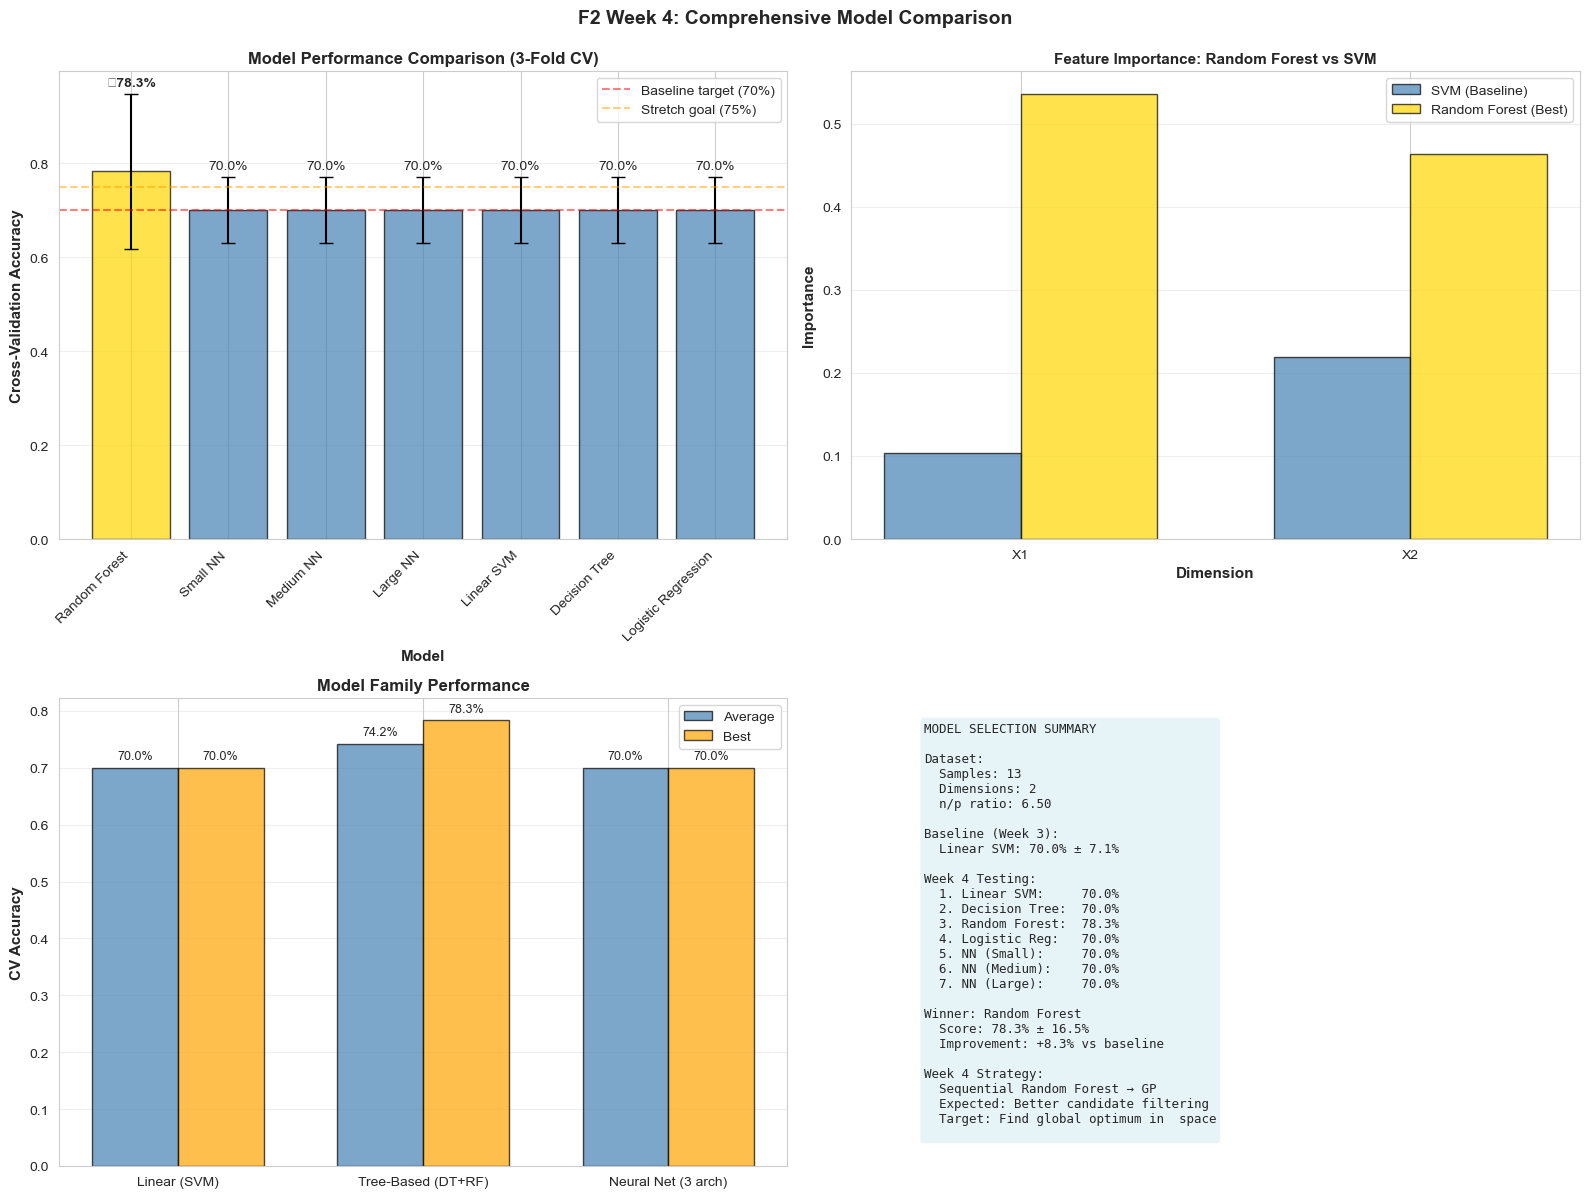


✓ Saved: F2_W4_Model_Comparison.png


In [38]:
# Dynamic variables from data
n_samples = len(X)
n_dims = X.shape[1]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ============================================================================
# Plot 1: CV Performance Comparison (ALL 4 MODELS)
# ============================================================================

ax = axes[0, 0]

# Collect all models
model_names = ['Linear SVM', 'Decision Tree', 'Random Forest', 'Logistic Regression'] + [r['architecture'].title() + ' NN' for r in nn_results]
model_scores = [svm_cv.mean(), tree_cv.mean(), rf_cv.mean(), logreg_cv.mean()] + [r['cv_mean'] for r in nn_results]
model_stds = [svm_cv.std(), tree_cv.std(), rf_cv.std(), logreg_cv.std()] + [r['cv_std'] for r in nn_results]

# Sort by score (descending)
sorted_idx = sorted(range(len(model_scores)), key=lambda i: model_scores[i], reverse=True)
model_names_sorted = [model_names[i] for i in sorted_idx]
model_scores_sorted = [model_scores[i] for i in sorted_idx]
model_stds_sorted = [model_stds[i] for i in sorted_idx]

# Create bar chart
x_pos = np.arange(len(model_names_sorted))
colors = ['gold' if i == 0 else 'steelblue' for i in range(len(model_names_sorted))]

bars = ax.bar(x_pos, model_scores_sorted, yerr=model_stds_sorted, 
              color=colors, alpha=0.7, edgecolor='black', capsize=5)

ax.set_xlabel('Model', fontweight='bold', fontsize=11)
ax.set_ylabel('Cross-Validation Accuracy', fontweight='bold', fontsize=11)
ax.set_title('Model Performance Comparison (3-Fold CV)', fontweight='bold', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names_sorted, rotation=45, ha='right')
ax.axhline(0.70, color='red', linestyle='--', alpha=0.5, label='Baseline target (70%)')
ax.axhline(0.75, color='orange', linestyle='--', alpha=0.5, label='Stretch goal (75%)')
ax.legend()
ax.grid(alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, score, std) in enumerate(zip(bars, model_scores_sorted, model_stds_sorted)):
    height = bar.get_height()
    label_y = height + std + 0.01
    marker = '★' if i == 0 else ''
    ax.text(bar.get_x() + bar.get_width()/2., label_y,
           f'{marker}{score:.1%}',
           ha='center', va='bottom', fontweight='bold' if i == 0 else 'normal',
           fontsize=10)

# ============================================================================
# Plot 2: Feature Importance Comparison (Top Model vs Baseline)
# ============================================================================

ax = axes[0, 1]

dims = np.arange(n_dims)
width = 0.35

# Compare top model with SVM baseline
top_model_name = model_names_sorted[0]
if 'Tree' in top_model_name:
    top_importance = tree_importance
elif 'Forest' in top_model_name:
    top_importance = rf_importance
elif 'Logistic' in top_model_name:
    top_importance = logreg_importance
    top_importance = rf_importance
elif 'NN' in top_model_name:
    top_importance = np.abs(grads)
else:
    top_importance = svm_importance

ax.bar(dims - width/2, svm_importance, width, label='SVM (Baseline)',
      alpha=0.7, color='steelblue', edgecolor='black')
ax.bar(dims + width/2, top_importance, width, label=f'{top_model_name} (Best)',
      alpha=0.7, color='gold', edgecolor='black')

ax.set_xlabel('Dimension', fontweight='bold', fontsize=11)
ax.set_ylabel('Importance', fontweight='bold', fontsize=11)
ax.set_title(f'Feature Importance: {top_model_name} vs SVM', fontweight='bold', fontsize=11)
ax.set_xticks(dims)
ax.set_xticklabels([f'X{i+1}' for i in dims])
ax.legend()
ax.grid(alpha=0.3, axis='y')

# ============================================================================
# Plot 3: Model Family Analysis
# ============================================================================

ax = axes[1, 0]

# Group by model family
linear_score = svm_cv.mean()
tree_based_scores = [tree_cv.mean(), rf_cv.mean()]
nn_scores = [r['cv_mean'] for r in nn_results]

families = ['Linear (SVM)', 'Tree-Based (DT+RF)', 'Neural Net (3 arch)']
family_means = [linear_score, np.mean(tree_based_scores), np.mean(nn_scores)]
family_maxes = [linear_score, max(tree_based_scores), max(nn_scores)]

x_fam = np.arange(len(families))
width_fam = 0.35

bars1 = ax.bar(x_fam - width_fam/2, family_means, width_fam, 
              label='Average', alpha=0.7, color='steelblue', edgecolor='black')
bars2 = ax.bar(x_fam + width_fam/2, family_maxes, width_fam,
              label='Best', alpha=0.7, color='orange', edgecolor='black')

ax.set_ylabel('CV Accuracy', fontweight='bold', fontsize=11)
ax.set_title('Model Family Performance', fontweight='bold', fontsize=12)
ax.set_xticks(x_fam)
ax.set_xticklabels(families)
ax.legend()
ax.grid(alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.1%}',
               ha='center', va='bottom', fontsize=9)

# ============================================================================
# Plot 4: Summary Statistics
# ============================================================================

ax = axes[1, 1]
ax.axis('off')

summary_text = f'''MODEL SELECTION SUMMARY

Dataset:
  Samples: {n_samples}
  Dimensions: {n_dims}
  n/p ratio: {n_samples/n_dims:.2f}

Baseline (Week 3):
  Linear SVM: {svm_cv.mean():.1%} ± {svm_cv.std():.1%}

Week 4 Testing:
  1. Linear SVM:     {svm_cv.mean():.1%}
  2. Decision Tree:  {tree_cv.mean():.1%}
  3. Random Forest:  {rf_cv.mean():.1%}
  4. Logistic Reg:   {logreg_cv.mean():.1%}
  5. NN (Small):     {nn_results[0]['cv_mean']:.1%}
  6. NN (Medium):    {nn_results[1]['cv_mean']:.1%}
  7. NN (Large):     {nn_results[2]['cv_mean']:.1%}

Winner: {model_names_sorted[0]}
  Score: {model_scores_sorted[0]:.1%} ± {model_stds_sorted[0]:.1%}
  Improvement: {model_scores_sorted[0] - svm_cv.mean():+.1%} vs baseline

Week 4 Strategy:
  Sequential {model_names_sorted[0]} → GP
  Expected: Better candidate filtering
  Target: Find global optimum in  space
'''

ax.text(0.1, 0.95, summary_text, transform=ax.transAxes,
       fontsize=9, verticalalignment='top', family='monospace',
       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle('F2 Week 4: Comprehensive Model Comparison', 
            fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('F2_W4_Model_Comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n✓ Saved: F2_W4_Model_Comparison.png')



## Model Selection: Pick Best for GP

In [39]:
# ============================================================================
# MODEL COMPARISON & SELECTION
# ============================================================================

print('\n' + '='*80)
print('MODEL COMPARISON: SELECT BEST FOR GP')
print('='*80)

# Collect all models
all_models = []

# Model 1: Linear SVM
all_models.append({
    'name': 'Linear SVM',
    'model': svm,
    'cv_mean': svm_cv.mean(),
    'cv_std': svm_cv.std(),
    'type': 'sklearn',
    'feature_importance': np.abs(svm_weights)
})

# Model 2: Decision Tree
all_models.append({
    'name': 'Decision Tree',
    'model': tree,
    'cv_mean': tree_cv.mean(),
    'cv_std': tree_cv.std(),
    'type': 'sklearn',
    'feature_importance': tree_importance
})

# Model 3: Random Forest
all_models.append({
    'name': 'Random Forest',
    'model': rf,
    'cv_mean': rf_cv.mean(),
    'cv_std': rf_cv.std(),
    'type': 'sklearn',
    'feature_importance': rf_importance
})

# Model 4: Logistic Regression
all_models.append({
    'name': 'Logistic Regression',
    'model': logreg,
    'cv_mean': logreg_cv.mean(),
    'cv_std': logreg_cv.std(),
    'type': 'sklearn',
    'feature_importance': logreg_importance
})

# Model 5: Neural Network
all_models.append({
    'name': f'{best_nn["architecture"].capitalize()} NN',
    'model': final_nn,
    'cv_mean': best_nn['cv_mean'],
    'cv_std': best_nn['cv_std'],
    'type': 'neural_network',
    'feature_importance': np.abs(grads)
})

# Sort by CV performance
all_models.sort(key=lambda x: x['cv_mean'], reverse=True)

# Display comparison
print(f'\n{"Rank":<6} {"Model":<22} {"CV Mean":<12} {"CV Std":<10} {"Type":<15}')
print('─'*75)

for rank, m in enumerate(all_models, 1):
    marker = '★' if rank == 1 else ' '
    print(f'{marker} #{rank:<4} {m["name"]:<22} {m["cv_mean"]:<12.1%} {m["cv_std"]:<10.1%} {m["type"]:<15}')

# Select best
best_model_info = all_models[0]

print('\n' + '='*80)
print(f'SELECTED: {best_model_info["name"].upper()}')
print('='*80)

print(f'\n  CV Performance: {best_model_info["cv_mean"]:.1%} ± {best_model_info["cv_std"]:.1%}')
print(f'  Type: {best_model_info["type"]}')

if len(all_models) > 1:
    margin = best_model_info['cv_mean'] - all_models[1]['cv_mean']
    print(f'\n  Margin over {all_models[1]["name"]}: {margin:+.1%}')
    if margin > 0.05:
        print(f'  → CLEAR WINNER!')
    elif margin > 0.02:
        print(f'  → Modest advantage')
    else:
        print(f'  → Close race')

# Feature importance
print('\n  Top 5 Important Dimensions:')
importance = best_model_info['feature_importance']
ranking = np.argsort(importance)[::-1]

for i, dim_idx in enumerate(ranking[:5]):
    print(f'    {i+1}. X{dim_idx+1}: {importance[dim_idx]:.4f}')

# Store for next cells
selected_model = best_model_info['model']
selected_model_name = best_model_info['name']
selected_model_type = best_model_info['type']




MODEL COMPARISON: SELECT BEST FOR GP

Rank   Model                  CV Mean      CV Std     Type           
───────────────────────────────────────────────────────────────────────────
★ #1    Random Forest          78.3%        16.5%      sklearn        
  #2    Small NN               70.0%        7.1%       neural_network 
  #3    Linear SVM             70.0%        7.1%       sklearn        
  #4    Decision Tree          70.0%        7.1%       sklearn        
  #5    Logistic Regression    70.0%        7.1%       sklearn        

SELECTED: RANDOM FOREST

  CV Performance: 78.3% ± 16.5%
  Type: sklearn

  Margin over Small NN: +8.3%
  → CLEAR WINNER!

  Top 5 Important Dimensions:
    1. X1: 0.5361
    2. X2: 0.4639


## Sequential: BEST MODEL → GP Optimization

In [40]:
# Dynamic variables from data
n_samples = len(X)
n_dims = X.shape[1]

print('\n' + '='*80)
print('SEQUENTIAL: BEST MODEL → GP OPTIMIZATION')
print('='*80)

# Train Gaussian Process
kernel = ConstantKernel(1.0) * Matern(0.3, nu=2.5) + WhiteKernel(1e-10)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50,
                              normalize_y=True, random_state=42)
gp.fit(X, Y)

print(f'\nGP R²: {gp.score(X, Y):.3f}')

# Expected Improvement function
def expected_improvement(X_new, gp, y_best, xi=0.10):
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-10)
    improvement = mu - y_best - xi
    Z = improvement / sigma
    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-10] = 0.0
    return ei

y_best = Y.max()

print(f'\nCurrent best value: {y_best:.6f}')
print(f'Target: Maximize (find higher value)')

# Generate candidate points
print(f'\n' + '─'*80)
print('CANDIDATE GENERATION')
print('─'*80)

np.random.seed(42)

# Strategy: 70% NN-approved + 30% Boundary LOW
X_candidates = np.random.uniform(0, 1, (10000, n_dims))

# Filter with Best Model
print(f'\nFiltering with {selected_model_name}...')

if selected_model_type == 'neural_network':
    # Neural Network prediction
    model_prob = selected_model.predict(X_candidates, verbose=0).flatten()
    model_pred = (model_prob > 0.5)
else:
    # Sklearn model (SVM, Tree, Forest)
    model_pred = selected_model.predict(X_candidates)
    model_prob = selected_model.predict_proba(X_candidates)[:, 1]

# Get approved candidates
if (model_pred == 1).sum() > 0:
    approved_idx = np.where(model_pred == 1)[0]
    confidence_order = np.argsort(model_prob[approved_idx])[::-1]
    X_model_approved = X_candidates[approved_idx[confidence_order[:7000]]]
    print(f'{selected_model_name} approved: {len(X_model_approved):,} candidates')
else:
    top_prob_idx = np.argsort(model_prob)[::-1][:7000]
    X_model_approved = X_candidates[top_prob_idx]
    print(f'{selected_model_name} approved: 0 exact, using top {len(X_model_approved):,} by probability')

# Boundary LOW candidates
X_boundary = []
for _ in range(20000):
    c = np.random.uniform(0, 1, n_dims)
    if np.any(c < 0.1):  # At least one dimension LOW
        X_boundary.append(c)
    if len(X_boundary) >= 3000:
        break
X_boundary = np.array(X_boundary[:3000])

print(f'Boundary LOW: {len(X_boundary):,} candidates')

# Combine
X_filtered = np.vstack([X_model_approved, X_boundary])
print(f'Total candidates: {len(X_filtered):,}')

# GP Expected Improvement
print(f'\n' + '─'*80)
print('GP OPTIMIZATION (Expected Improvement)')
print('─'*80)

ei = expected_improvement(X_filtered, gp, y_best, xi=0.10)
mu, sigma = gp.predict(X_filtered, return_std=True)

best_idx = np.argmax(ei)
x_next = X_filtered[best_idx]
mu_next = mu[best_idx]
sigma_next = sigma[best_idx]
ei_next = ei[best_idx]

# Determine source
if best_idx < len(X_model_approved):
    source = f"{selected_model_name}-APPROVED"
else:
    source = 'BOUNDARY LOW'

print(f'\nWeek 4 Recommendation:')
print(f'  Point: {x_next}')
print(f'  Source: {source}')
print(f'  GP μ: {mu_next:.6f}')
print(f'  GP σ: {sigma_next:.6f}')
print(f'  EI: {ei_next:.8f}')

# Analysis
boundary_dims = [i for i, val in enumerate(x_next) if val < 0.1 or val > 0.9]
if boundary_dims:
    print(f'\n  Boundary dimensions: {[f"X{i+1}" for i in boundary_dims]}')

# Compare to Week 3
dist_from_w3 = np.linalg.norm(x_next - w3_best_pt)
print(f'\n  Distance from Week 3: {dist_from_w3:.4f}')

# Model's opinion of this point
if selected_model_type == 'neural_network':
    nn_confidence = selected_model.predict(x_next.reshape(1, -1), verbose=0)[0][0]
else:
    nn_confidence = selected_model.predict_proba(x_next.reshape(1, -1))[0, 1]


# Gradient analysis (only for Neural Network)
if selected_model_type == 'neural_network':
    # Gradient at this point
    x_next_input = tf.Variable(x_next.reshape(1, -1).astype(np.float32))
    with tf.GradientTape() as tape:
        pred_next = selected_model(x_next_input)  # Only runs for NN
    grads_at_next = tape.gradient(pred_next, x_next_input).numpy()[0]
    top_grad_dim = np.argmax(np.abs(grads_at_next))
    print(f'  Steepest gradient: X{top_grad_dim+1} ({grads_at_next[top_grad_dim]:+.4f})')
else:
    # For sklearn models, use feature importance instead
    print(f'  Feature importance analysis (not gradient-based)')
  



SEQUENTIAL: BEST MODEL → GP OPTIMIZATION

GP R²: 0.401

Current best value: 0.611205
Target: Maximize (find higher value)

────────────────────────────────────────────────────────────────────────────────
CANDIDATE GENERATION
────────────────────────────────────────────────────────────────────────────────

Filtering with Random Forest...
Random Forest approved: 1,899 candidates
Boundary LOW: 3,000 candidates
Total candidates: 4,899

────────────────────────────────────────────────────────────────────────────────
GP OPTIMIZATION (Expected Improvement)
────────────────────────────────────────────────────────────────────────────────

Week 4 Recommendation:
  Point: [0.78093318 0.99150769]
  Source: Random Forest-APPROVED
  GP μ: 0.374538
  GP σ: 0.216120
  EI: 0.00554495

  Boundary dimensions: ['X2']

  Distance from Week 3: 0.1017
  Feature importance analysis (not gradient-based)



EXPECTED IMPROVEMENT VISUALIZATION

DIMENSION-WISE ACQUISITION CURVES PLOTS

Generating curve for X1...

Generating curve for X2...


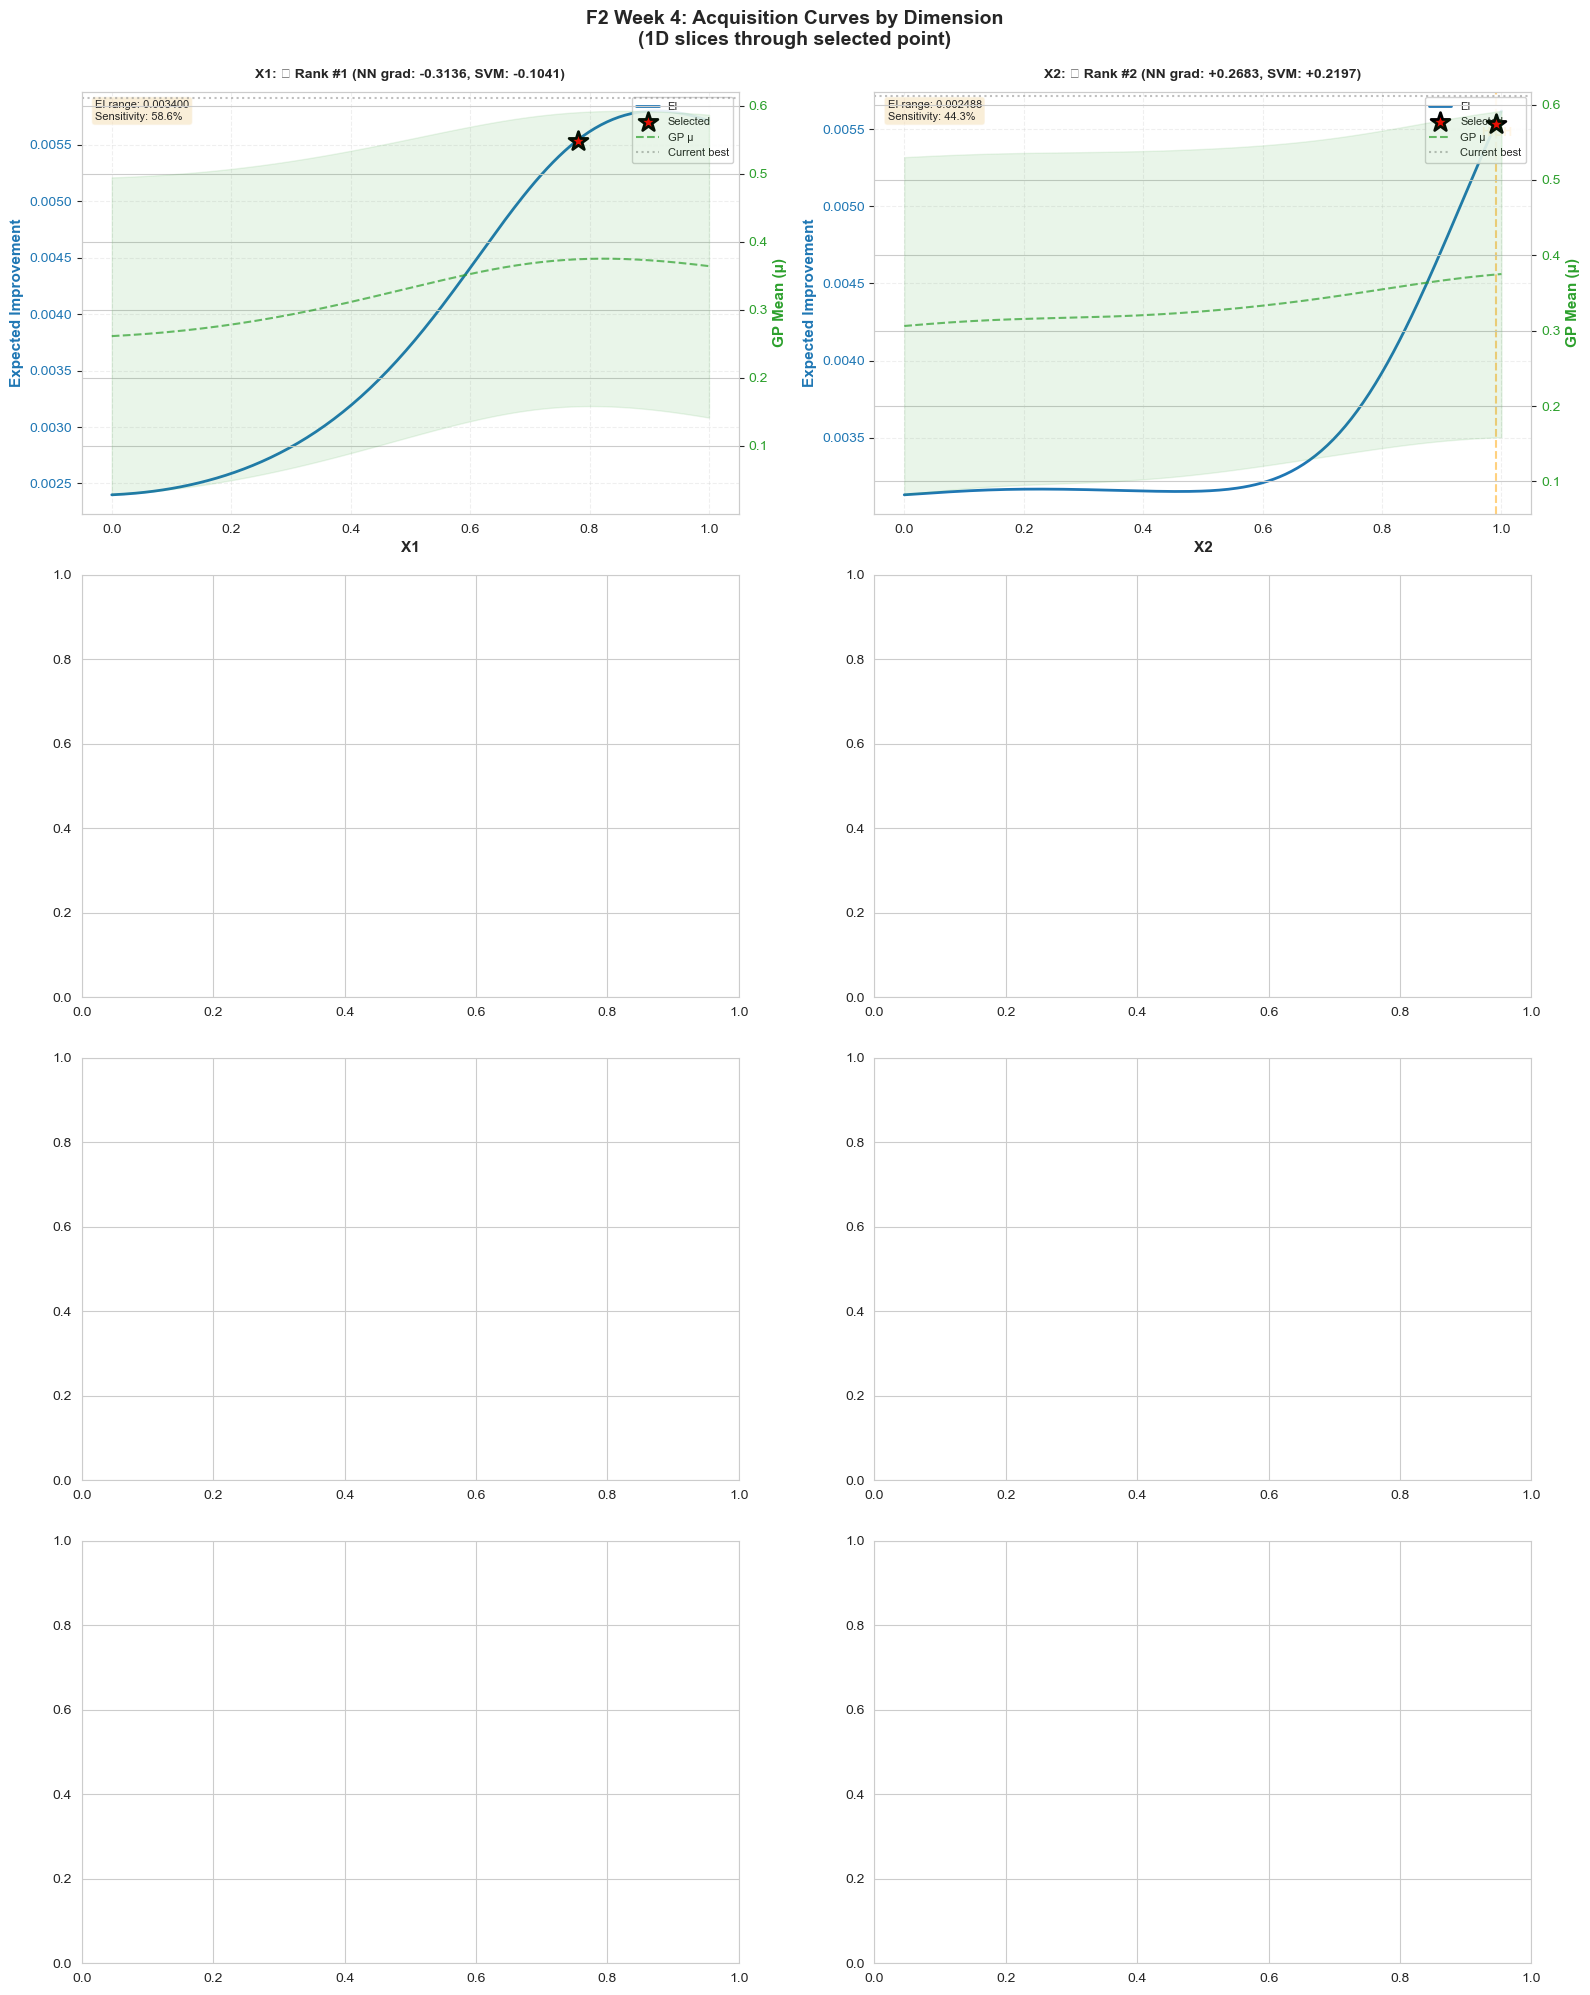


✓ Saved: F2_W4_Acquisition_Curves.png

DIMENSION SENSITIVITY ANALYSIS

Rank   Dim    EI Range     Max EI       Selected   NN Grad    SVM Weight
────────────────────────────────────────────────────────────────────────────────
1      X1     0.003400     0.005800     0.7809     -0.3136    -0.1041
2      X2     0.002488     0.005619     0.9915     +0.2683    +0.2197

INTERPRETATION:

Most Sensitive Dimensions (by EI range):
  1. X1: EI range = 0.003400
     → Small changes in X1 cause LARGE changes in EI
     → CRITICAL dimension for optimization
  2. X2: EI range = 0.002488
     → Small changes in X2 cause LARGE changes in EI
     → CRITICAL dimension for optimization

Least Sensitive Dimensions:
  1. X1: EI range = 0.003400
     → Changes in X1 have MINIMAL effect on EI
     → Can fix at boundary (current: 0.7809)
  2. X2: EI range = 0.002488
     → Changes in X2 have MINIMAL effect on EI
     → Can fix at boundary (current: 0.9915)

CORRELATION: EI Sensitivity vs NN Gradient

Correlati

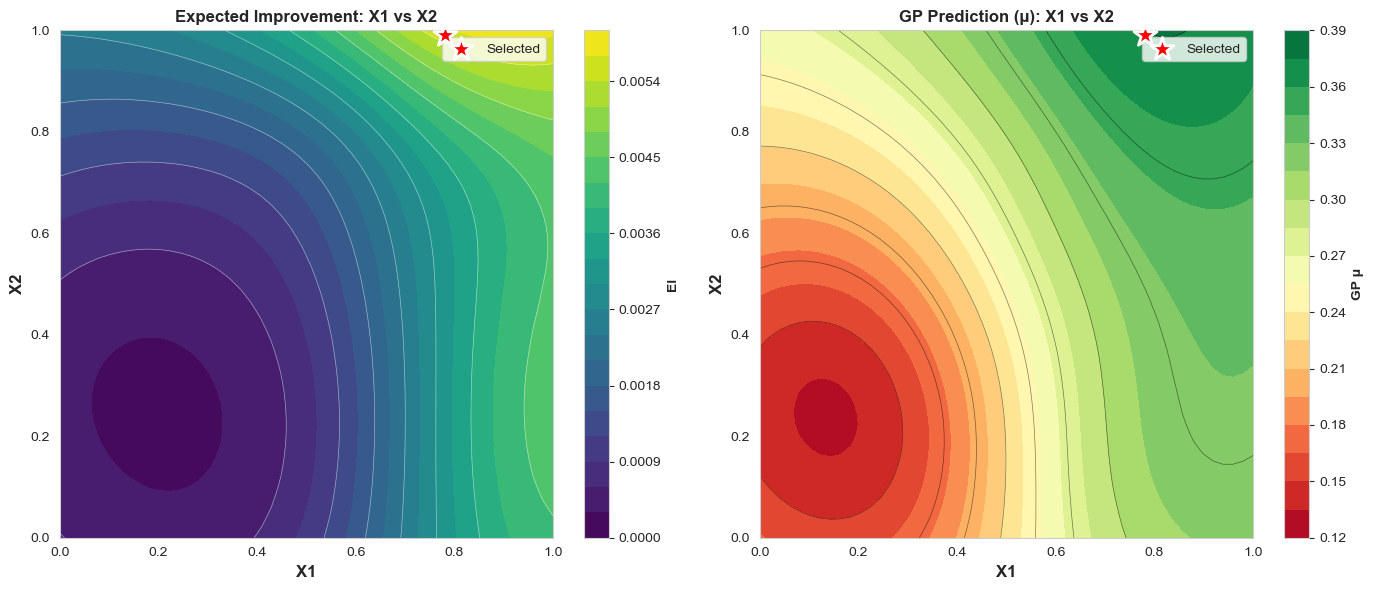


✓ Saved: F2_W4_2D_Acquisition_Surface.png

✓ ALL ACQUISITION VISUALIZATIONS COMPLETE! 🎉


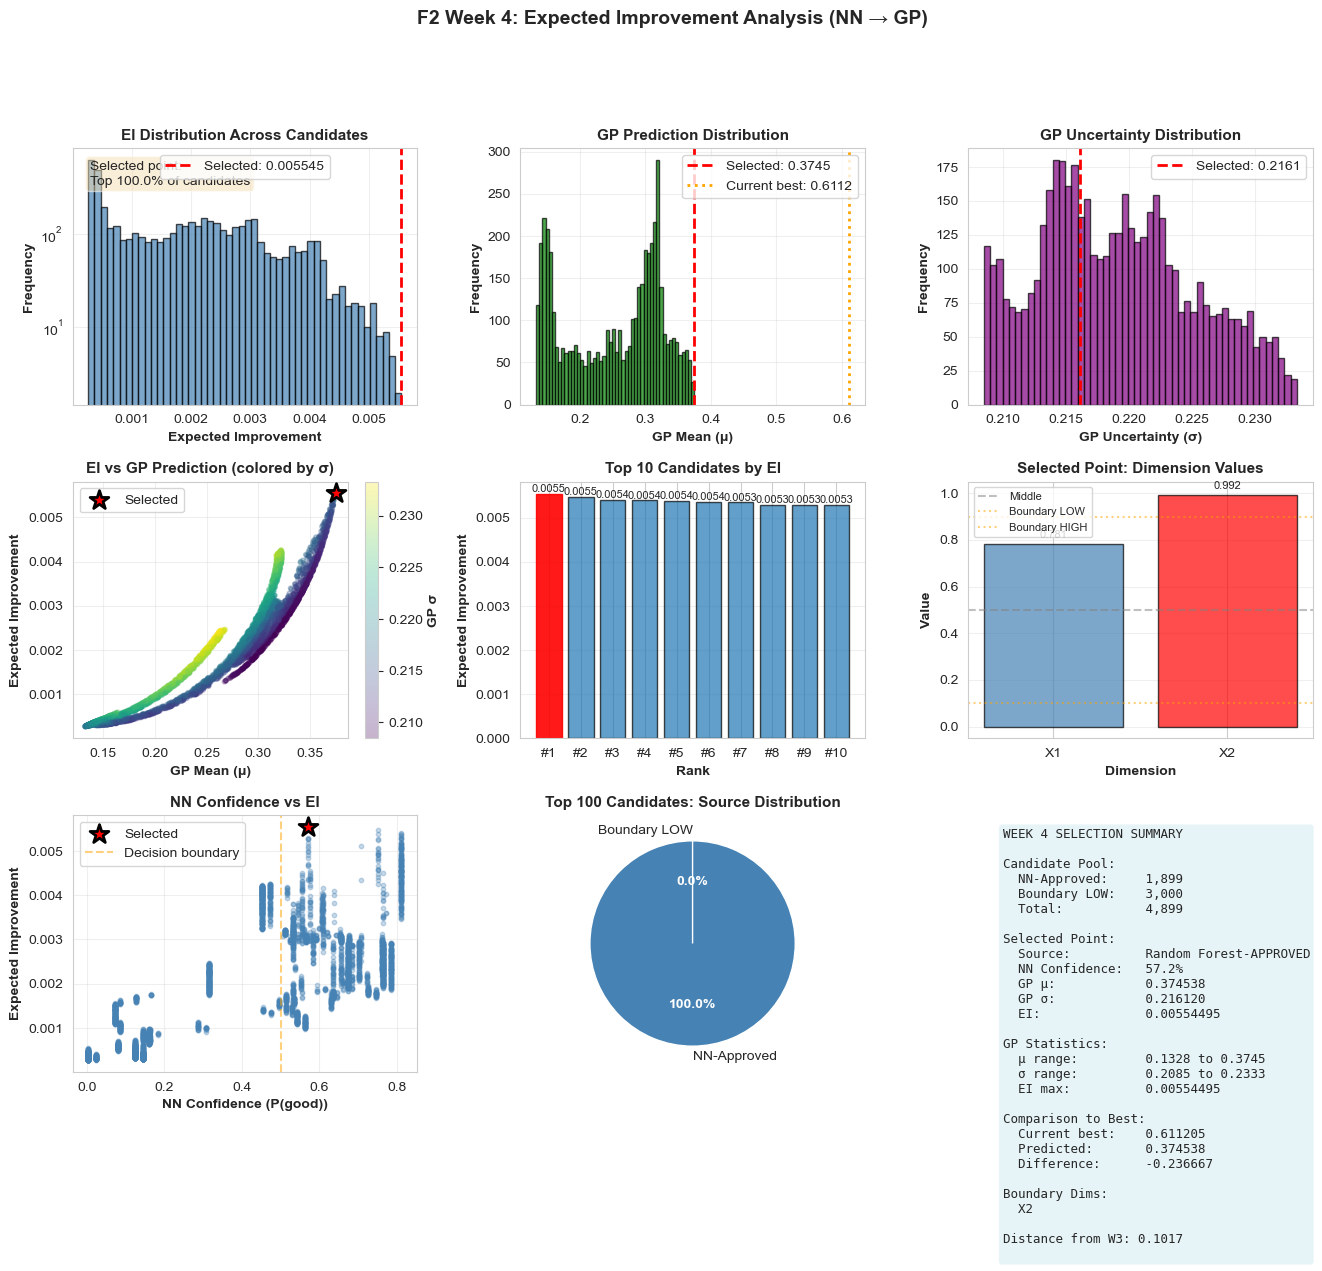


✓ Saved: F2_W4_EI_Visualization.png

EI DECOMPOSITION FOR SELECTED POINT

Selected Point EI Breakdown:
  Total EI:              0.00554495
  Exploitation term:     -0.02007981 (-362.1%)
  Exploration term:      0.02562477 (462.1%)

  μ - y_best:            -0.236667
  σ (uncertainty):       0.216120
  Z-score:               -1.5578

  → EI driven by EXPLORATION (high uncertainty)

COMPARISON: TOP 5 CANDIDATES

Rank   EI           GP μ       GP σ       NN Conf    Source
──────────────────────────────────────────────────────────────────────
✓ #1    0.00554495   0.374538   0.216120   57.2%      NN-Approved
  #2    0.00547515   0.373783   0.215908   75.2%      NN-Approved
  #3    0.00540768   0.372706   0.215872   81.2%      NN-Approved
  #4    0.00539129   0.372697   0.215737   81.2%      NN-Approved
  #5    0.00538217   0.372874   0.215570   75.2%      NN-Approved

✓ EI VISUALIZATION COMPLETE!


In [41]:
#============================================================================
# EXPECTED IMPROVEMENT VISUALIZATIONS
# ============================================================================

# Dynamic variables from data
n_samples = len(X)
n_dims = X.shape[1]

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print('\n' + '='*80)
print('EXPECTED IMPROVEMENT VISUALIZATION')
print('='*80)

#Visuals for Acquisition curves first
###

# ============================================================================
# DIMENSION-WISE ACQUISITION CURVES (1D SLICES)
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

print('\n' + '='*80)
print('DIMENSION-WISE ACQUISITION CURVES PLOTS')
print('='*80)

# Expected Improvement function (redefine for clarity)
def compute_ei_1d(x_samples, gp, y_best, xi=0.10):
    """Compute EI for array of samples"""
    mu, sigma = gp.predict(x_samples, return_std=True)
    sigma = np.maximum(sigma, 1e-10)
    improvement = mu - y_best - xi
    Z = improvement / sigma
    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-10] = 0.0
    return ei, mu, sigma

# Create figure: 4x2 grid for 6 dimensions
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

# For each dimension, create 1D slice
for dim_idx in range(n_dims):
    ax = axes[dim_idx]
    
    print(f'\nGenerating curve for X{dim_idx+1}...')
    
    # Create 1D slice: vary this dimension, fix others at selected point
    x_range = np.linspace(0, 1, 200)
    
    # Build candidates: each row varies only dimension dim_idx
    X_slice = np.tile(x_next, (200, 1))  # Start with selected point repeated
    X_slice[:, dim_idx] = x_range  # Vary this dimension
    
    # Compute EI, mu, sigma for all points in slice
    ei_slice, mu_slice, sigma_slice = compute_ei_1d(X_slice, gp, y_best, xi=0.10)
    
    # Plot 1: Expected Improvement
    ax_ei = ax
    color_ei = 'tab:blue'
    ax_ei.plot(x_range, ei_slice, color=color_ei, linewidth=2, label='EI')
    ax_ei.set_xlabel(f'X{dim_idx+1}', fontweight='bold', fontsize=11)
    ax_ei.set_ylabel('Expected Improvement', color=color_ei, fontweight='bold', fontsize=11)
    ax_ei.tick_params(axis='y', labelcolor=color_ei)
    
    # Mark selected point
    selected_val = x_next[dim_idx]
    selected_ei = ei_slice[np.argmin(np.abs(x_range - selected_val))]
    ax_ei.scatter([selected_val], [selected_ei], color='red', s=200, marker='*', 
                 edgecolors='black', linewidths=2, zorder=10, label='Selected')
    
    # Mark boundaries if applicable
    if selected_val < 0.1:
        ax_ei.axvline(selected_val, color='orange', linestyle='--', alpha=0.5, linewidth=1.5)
        ax_ei.text(selected_val, ax_ei.get_ylim()[1]*0.95, 'LOW', 
                  ha='center', fontsize=9, color='orange', fontweight='bold')
    elif selected_val > 0.9:
        ax_ei.axvline(selected_val, color='orange', linestyle='--', alpha=0.5, linewidth=1.5)
        ax_ei.text(selected_val, ax_ei.get_ylim()[1]*0.95, 'HIGH', 
                  ha='center', fontsize=9, color='orange', fontweight='bold')
    
    # Add GP mean (mu) on secondary y-axis
    ax_mu = ax_ei.twinx()
    color_mu = 'tab:green'
    ax_mu.plot(x_range, mu_slice, color=color_mu, linewidth=1.5, 
              linestyle='--', alpha=0.7, label='GP μ')
    ax_mu.set_ylabel('GP Mean (μ)', color=color_mu, fontweight='bold', fontsize=11)
    ax_mu.tick_params(axis='y', labelcolor=color_mu)
    
    # Shade uncertainty (μ ± σ)
    ax_mu.fill_between(x_range, mu_slice - sigma_slice, mu_slice + sigma_slice,
                       color=color_mu, alpha=0.1)
    
    # Add current best line
    ax_mu.axhline(y_best, color='gray', linestyle=':', linewidth=1.5, 
                 alpha=0.5, label='Current best')
    
    # Title with dimension importance
    nn_grad = grads[dim_idx]
    svm_weight = svm_weights[dim_idx]
    importance_rank = np.where(nn_ranking == dim_idx)[0][0] + 1
    
    title = f'X{dim_idx+1}: '
    if importance_rank <= 3:
        title += f'★ Rank #{importance_rank} '
    title += f'(NN grad: {nn_grad:+.4f}, SVM: {svm_weight:+.4f})'
    
    ax_ei.set_title(title, fontweight='bold', fontsize=10, pad=10)
    
    # Grid
    ax_ei.grid(alpha=0.3, linestyle='--')
    
    # Legend
    lines1, labels1 = ax_ei.get_legend_handles_labels()
    lines2, labels2 = ax_mu.get_legend_handles_labels()
    ax_ei.legend(lines1 + lines2, labels1 + labels2, 
                loc='upper right', fontsize=8, framealpha=0.9)
    
    # Add stats box
    ei_max = ei_slice.max()
    ei_range = ei_slice.max() - ei_slice.min()
    sensitivity = ei_range / ei_max if ei_max > 0 else 0
    
    stats_text = f'EI range: {ei_range:.6f}\n'
    stats_text += f'Sensitivity: {sensitivity:.1%}'
    
    ax_ei.text(0.02, 0.98, stats_text, transform=ax_ei.transAxes,
              verticalalignment='top', fontsize=8,
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('F2 Week 4: Acquisition Curves by Dimension\n' + 
             '(1D slices through selected point)', 
             fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('F2_W4_Acquisition_Curves.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n✓ Saved: F2_W4_Acquisition_Curves.png')

# ============================================================================
# DIMENSION SENSITIVITY ANALYSIS
# ============================================================================

print('\n' + '='*80)
print('DIMENSION SENSITIVITY ANALYSIS')
print('='*80)

# For each dimension, compute EI sensitivity
sensitivities = []

for dim_idx in range(n_dims):
    # Create 1D slice
    x_range = np.linspace(0, 1, 100)
    X_slice = np.tile(x_next, (100, 1))
    X_slice[:, dim_idx] = x_range
    
    # Compute EI
    ei_slice, _, _ = compute_ei_1d(X_slice, gp, y_best, xi=0.10)
    
    # Sensitivity = range of EI values
    ei_range = ei_slice.max() - ei_slice.min()
    sensitivities.append({
        'dim': dim_idx + 1,
        'range': ei_range,
        'max_ei': ei_slice.max(),
        'selected_val': x_next[dim_idx],
        'nn_grad': grads[dim_idx],
        'svm_weight': svm_weights[dim_idx]
    })

# Sort by EI range (most sensitive first)
sensitivities.sort(key=lambda x: x['range'], reverse=True)

print(f'\n{"Rank":<6} {"Dim":<6} {"EI Range":<12} {"Max EI":<12} {"Selected":<10} {"NN Grad":<10} {"SVM Weight"}')
print('─'*80)

for rank, s in enumerate(sensitivities, 1):
    print(f'{rank:<6} X{s["dim"]:<5} {s["range"]:<12.6f} {s["max_ei"]:<12.6f} '
          f'{s["selected_val"]:<10.4f} {s["nn_grad"]:<+10.4f} {s["svm_weight"]:+.4f}')

print('\n' + '='*80)
print('INTERPRETATION:')
print('='*80)

print('\nMost Sensitive Dimensions (by EI range):')
for i in range(min(3, len(sensitivities))):
    s = sensitivities[i]
    print(f'  {i+1}. X{s["dim"]}: EI range = {s["range"]:.6f}')
    print(f'     → Small changes in X{s["dim"]} cause LARGE changes in EI')
    print(f'     → CRITICAL dimension for optimization')

print('\nLeast Sensitive Dimensions:')
for i in range(max(0, len(sensitivities)-3), len(sensitivities)):
    s = sensitivities[i]
    print(f'  {i+1}. X{s["dim"]}: EI range = {s["range"]:.6f}')
    print(f'     → Changes in X{s["dim"]} have MINIMAL effect on EI')
    print(f'     → Can fix at boundary (current: {s["selected_val"]:.4f})')

# ============================================================================
# CORRELATION: EI Sensitivity vs NN Gradient
# ============================================================================

print('\n' + '='*80)
print('CORRELATION: EI Sensitivity vs NN Gradient')
print('='*80)

ei_ranges = [s['range'] for s in sensitivities]
nn_grads_abs = [abs(s['nn_grad']) for s in sensitivities]

correlation = np.corrcoef(ei_ranges, nn_grads_abs)[0, 1]

print(f'\nCorrelation: {correlation:.3f}')

if correlation > 0.7:
    print('→ STRONG correlation! NN gradients predict EI sensitivity ✓')
    print('→ Can use NN gradients to identify important dimensions')
elif correlation > 0.3:
    print('→ Moderate correlation between NN gradients and EI sensitivity')
else:
    print('→ Weak correlation - NN and GP identify different sensitivities')
    print('→ Both perspectives valuable!')

print('\n✓ ACQUISITION CURVES COMPLETE!')

# ============================================================================
# OPTIONAL: 2D HEATMAP (Top 2 Dimensions)
# ============================================================================

print('\n' + '='*80)
print('BONUS: 2D ACQUISITION SURFACE (TOP 2 DIMENSIONS)')
print('='*80)

# Get top 2 most sensitive dimensions
top_dim1 = sensitivities[0]['dim'] - 1  # Convert to 0-indexed
top_dim2 = sensitivities[1]['dim'] - 1

print(f'\nCreating 2D surface for X{top_dim1+1} vs X{top_dim2+1}...')

# Create 2D grid
n_grid = 50
x1_range = np.linspace(0, 1, n_grid)
x2_range = np.linspace(0, 1, n_grid)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)

# Build candidates
X_2d = np.tile(x_next, (n_grid * n_grid, 1))
X_2d[:, top_dim1] = X1_grid.ravel()
X_2d[:, top_dim2] = X2_grid.ravel()

# Compute EI
ei_2d, mu_2d, sigma_2d = compute_ei_1d(X_2d, gp, y_best, xi=0.10)
EI_grid = ei_2d.reshape(n_grid, n_grid)
MU_grid = mu_2d.reshape(n_grid, n_grid)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: EI Heatmap
im1 = ax1.contourf(X1_grid, X2_grid, EI_grid, levels=20, cmap='viridis')
ax1.contour(X1_grid, X2_grid, EI_grid, levels=10, colors='white', 
           linewidths=0.5, alpha=0.5)
ax1.scatter([x_next[top_dim1]], [x_next[top_dim2]], color='red', s=300, 
           marker='*', edgecolors='white', linewidths=2, zorder=10, label='Selected')
ax1.set_xlabel(f'X{top_dim1+1}', fontweight='bold', fontsize=12)
ax1.set_ylabel(f'X{top_dim2+1}', fontweight='bold', fontsize=12)
ax1.set_title(f'Expected Improvement: X{top_dim1+1} vs X{top_dim2+1}', 
             fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3, color='white', linestyle='--')
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('EI', fontweight='bold')

# Plot 2: GP Mean Heatmap
im2 = ax2.contourf(X1_grid, X2_grid, MU_grid, levels=20, cmap='RdYlGn')
ax2.contour(X1_grid, X2_grid, MU_grid, levels=10, colors='black', 
           linewidths=0.5, alpha=0.5)
ax2.scatter([x_next[top_dim1]], [x_next[top_dim2]], color='red', s=300,
           marker='*', edgecolors='white', linewidths=2, zorder=10, label='Selected')
ax2.set_xlabel(f'X{top_dim1+1}', fontweight='bold', fontsize=12)
ax2.set_ylabel(f'X{top_dim2+1}', fontweight='bold', fontsize=12)
ax2.set_title(f'GP Prediction (μ): X{top_dim1+1} vs X{top_dim2+1}', 
             fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3, color='white', linestyle='--')
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('GP μ', fontweight='bold')

plt.tight_layout()
plt.savefig('F2_W4_2D_Acquisition_Surface.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n✓ Saved: F2_W4_2D_Acquisition_Surface.png')
print('\n✓ ALL ACQUISITION VISUALIZATIONS COMPLETE! 🎉')
###
# Create figure with 6 subplots
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# ============================================================================
# Plot 1: EI Distribution
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])

# Plot EI histogram
ei_positive = ei[ei > 0]
if len(ei_positive) > 0:
    ax1.hist(ei_positive, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax1.axvline(ei_next, color='red', linestyle='--', linewidth=2, label=f'Selected: {ei_next:.6f}')
    ax1.set_xlabel('Expected Improvement', fontweight='bold')
    ax1.set_ylabel('Frequency', fontweight='bold')
    ax1.set_title('EI Distribution Across Candidates', fontweight='bold', fontsize=11)
    ax1.legend()
    ax1.grid(alpha=0.3)
    ax1.set_yscale('log')
    
    # Add stats
    percentile = (ei > ei_next).sum() / len(ei) * 100
    ax1.text(0.05, 0.95, f'Selected point:\nTop {100-percentile:.1f}% of candidates',
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ============================================================================
# Plot 2: GP Mean (μ) Distribution
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1])

ax2.hist(mu, bins=50, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(mu_next, color='red', linestyle='--', linewidth=2, label=f'Selected: {mu_next:.4f}')
ax2.axvline(y_best, color='orange', linestyle=':', linewidth=2, label=f'Current best: {y_best:.4f}')
ax2.set_xlabel('GP Mean (μ)', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('GP Prediction Distribution', fontweight='bold', fontsize=11)
ax2.legend()
ax2.grid(alpha=0.3)

# ============================================================================
# Plot 3: GP Uncertainty (σ) Distribution
# ============================================================================
ax3 = fig.add_subplot(gs[0, 2])

ax3.hist(sigma, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax3.axvline(sigma_next, color='red', linestyle='--', linewidth=2, label=f'Selected: {sigma_next:.4f}')
ax3.set_xlabel('GP Uncertainty (σ)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('GP Uncertainty Distribution', fontweight='bold', fontsize=11)
ax3.legend()
ax3.grid(alpha=0.3)

# ============================================================================
# Plot 4: EI vs GP Mean (μ)
# ============================================================================
ax4 = fig.add_subplot(gs[1, 0])

# Scatter plot with density coloring
scatter = ax4.scatter(mu, ei, c=sigma, cmap='viridis', alpha=0.3, s=10)
ax4.scatter(mu_next, ei_next, color='red', s=200, marker='*', 
           edgecolors='black', linewidths=2, label='Selected', zorder=10)

ax4.set_xlabel('GP Mean (μ)', fontweight='bold')
ax4.set_ylabel('Expected Improvement', fontweight='bold')
ax4.set_title('EI vs GP Prediction (colored by σ)', fontweight='bold', fontsize=11)
ax4.legend()
ax4.grid(alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('GP σ', fontweight='bold')

# ============================================================================
# Plot 5: Top 10 Candidates
# ============================================================================
ax5 = fig.add_subplot(gs[1, 1])

# Get top 10 EI candidates
top_10_idx = np.argsort(ei)[::-1][:10]
top_10_ei = ei[top_10_idx]
top_10_mu = mu[top_10_idx]
top_10_sigma = sigma[top_10_idx]

x_pos = np.arange(10)
bars = ax5.bar(x_pos, top_10_ei, alpha=0.7, edgecolor='black')
bars[0].set_color('red')  # Highlight selected (should be #1)
bars[0].set_alpha(0.9)

ax5.set_xlabel('Rank', fontweight='bold')
ax5.set_ylabel('Expected Improvement', fontweight='bold')
ax5.set_title('Top 10 Candidates by EI', fontweight='bold', fontsize=11)
ax5.set_xticks(x_pos)
ax5.set_xticklabels([f'#{i+1}' for i in range(10)])
ax5.grid(alpha=0.3, axis='y')

# Add values on bars
for i, (bar, ei_val) in enumerate(zip(bars, top_10_ei)):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{ei_val:.4f}',
            ha='center', va='bottom', fontsize=8)

# ============================================================================
# Plot 6: Selected Point Analysis by Dimension
# ============================================================================
ax6 = fig.add_subplot(gs[1, 2])

dims = np.arange(n_dims)
colors = ['red' if val < 0.1 or val > 0.9 else 'steelblue' for val in x_next]

bars = ax6.bar(dims, x_next, alpha=0.7, color=colors, edgecolor='black')
ax6.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Middle')
ax6.axhline(0.1, color='orange', linestyle=':', alpha=0.5, label='Boundary LOW')
ax6.axhline(0.9, color='orange', linestyle=':', alpha=0.5, label='Boundary HIGH')

ax6.set_xlabel('Dimension', fontweight='bold')
ax6.set_ylabel('Value', fontweight='bold')
ax6.set_title('Selected Point: Dimension Values', fontweight='bold', fontsize=11)
ax6.set_xticks(dims)
ax6.set_xticklabels([f'X{i+1}' for i in dims])
ax6.set_ylim(-0.05, 1.05)
ax6.legend(fontsize=8)
ax6.grid(alpha=0.3, axis='y')

# Add values on bars
for i, (bar, val) in enumerate(zip(bars, x_next)):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{val:.3f}',
            ha='center', va='bottom', fontsize=8, rotation=0)

# ============================================================================
# Plot 7: NN Confidence vs EI
# ============================================================================
ax7 = fig.add_subplot(gs[2, 0])

# Get NN confidence for all candidates
# Get model confidence for all filtered candidates
if selected_model_type == 'neural_network':
    nn_conf_all = selected_model.predict(X_filtered, verbose=0).flatten()
else:
    nn_conf_all = selected_model.predict_proba(X_filtered)[:, 1]


# Scatter
scatter = ax7.scatter(nn_conf_all, ei, alpha=0.3, s=10, c='steelblue')
ax7.scatter(nn_confidence, ei_next, color='red', s=200, marker='*',
           edgecolors='black', linewidths=2, label='Selected', zorder=10)

ax7.set_xlabel('NN Confidence (P(good))', fontweight='bold')
ax7.set_ylabel('Expected Improvement', fontweight='bold')
ax7.set_title('NN Confidence vs EI', fontweight='bold', fontsize=11)
ax7.axvline(0.5, color='orange', linestyle='--', alpha=0.5, label='Decision boundary')
ax7.legend()
ax7.grid(alpha=0.3)

# ============================================================================
# Plot 8: Candidate Source Distribution
# ============================================================================
ax8 = fig.add_subplot(gs[2, 1])

# Determine source for top 100 candidates
top_100_idx = np.argsort(ei)[::-1][:100]
sources = []
for idx in top_100_idx:
    if idx < len(X_model_approved):
        sources.append('NN-Approved')
    else:
        sources.append('Boundary LOW')

source_counts = {
    'NN-Approved': sources.count('NN-Approved'),
    'Boundary LOW': sources.count('Boundary LOW')
}

colors_pie = ['steelblue', 'orange']
wedges, texts, autotexts = ax8.pie(source_counts.values(), 
                                     labels=source_counts.keys(),
                                     autopct='%1.1f%%',
                                     colors=colors_pie,
                                     startangle=90,
                                     explode=(0.05 if source == 'NN-Approved' else 0,
                                             0.05 if source == 'Boundary LOW' else 0))

ax8.set_title('Top 100 Candidates: Source Distribution', fontweight='bold', fontsize=11)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# ============================================================================
# Plot 9: Summary Statistics
# ============================================================================
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')

summary_text = f'''WEEK 4 SELECTION SUMMARY

Candidate Pool:
  NN-Approved:     {len(X_model_approved):,}
  Boundary LOW:    {len(X_boundary):,}
  Total:           {len(X_filtered):,}

Selected Point:
  Source:          {source}
  NN Confidence:   {nn_confidence:.1%}
  GP μ:            {mu_next:.6f}
  GP σ:            {sigma_next:.6f}
  EI:              {ei_next:.8f}
  
GP Statistics:
  μ range:         {mu.min():.4f} to {mu.max():.4f}
  σ range:         {sigma.min():.4f} to {sigma.max():.4f}
  EI max:          {ei.max():.8f}
  
Comparison to Best:
  Current best:    {y_best:.6f}
  Predicted:       {mu_next:.6f}
  Difference:      {mu_next - y_best:+.6f}
  
Boundary Dims:
  {', '.join([f'X{i+1}' for i in boundary_dims]) if boundary_dims else 'None'}

Distance from W3: {dist_from_w3:.4f}
'''

ax9.text(0.1, 0.95, summary_text, transform=ax9.transAxes,
        fontsize=9, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# ============================================================================
# Save and Display
# ============================================================================

plt.suptitle('F2 Week 4: Expected Improvement Analysis (NN → GP)', 
             fontsize=14, fontweight='bold', y=0.995)

plt.savefig('F2_W4_EI_Visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n✓ Saved: F2_W4_EI_Visualization.png')

# ============================================================================
# Additional Analysis: EI Decomposition
# ============================================================================

print('\n' + '='*80)
print('EI DECOMPOSITION FOR SELECTED POINT')
print('='*80)

# EI = (μ - y_best - ξ) * Φ(Z) + σ * φ(Z)
xi_val = 0.10
improvement = mu_next - y_best - xi_val
Z = improvement / sigma_next

from scipy.stats import norm
exploitation_term = improvement * norm.cdf(Z)
exploration_term = sigma_next * norm.pdf(Z)

print(f'\nSelected Point EI Breakdown:')
print(f'  Total EI:              {ei_next:.8f}')
print(f'  Exploitation term:     {exploitation_term:.8f} ({exploitation_term/ei_next*100:.1f}%)')
print(f'  Exploration term:      {exploration_term:.8f} ({exploration_term/ei_next*100:.1f}%)')
print(f'\n  μ - y_best:            {mu_next - y_best:+.6f}')
print(f'  σ (uncertainty):       {sigma_next:.6f}')
print(f'  Z-score:               {Z:.4f}')

if exploitation_term > exploration_term:
    print(f'\n  → EI driven by EXPLOITATION (predicted improvement)')
else:
    print(f'\n  → EI driven by EXPLORATION (high uncertainty)')

# ============================================================================
# Compare with Alternative Candidates
# ============================================================================

print('\n' + '='*80)
print('COMPARISON: TOP 5 CANDIDATES')
print('='*80)

top_5_idx = np.argsort(ei)[::-1][:5]

print(f'\n{"Rank":<6} {"EI":<12} {"GP μ":<10} {"GP σ":<10} {"NN Conf":<10} {"Source"}')
print('─'*70)

for rank, idx in enumerate(top_5_idx, 1):
    candidate_ei = ei[idx]
    candidate_mu = mu[idx]
    candidate_sigma = sigma[idx]
    candidate_nn = nn_conf_all[idx]
    candidate_source = 'NN-Approved' if idx < len(X_model_approved) else 'Boundary'
    
    marker = '✓' if rank == 1 else ' '
    print(f'{marker} #{rank:<4} {candidate_ei:<12.8f} {candidate_mu:<10.6f} '
          f'{candidate_sigma:<10.6f} {candidate_nn:<10.1%} {candidate_source}')

print('\n✓ EI VISUALIZATION COMPLETE!')


## Format Week 4 Submission

In [42]:
# ============================================================================
# FORMAT WEEK 4 SUBMISSION
# ============================================================================

submission = '-'.join([f'{v:.6f}' for v in x_next])

print('\n' + '='*80)
print('WEEK 4 SUBMISSION')
print('='*80)
print(f'\n📋 COPY THIS:\n')
print(submission)
print('\n' + '='*80)

# Save to file

with open('F2_W4_Submission.txt', 'w', encoding='utf-8') as f:
    f.write(f'WEEK 4: Adaptive Model Selection -> GP\n')
    f.write('='*80 + '\n\n')
    f.write(f'Submission:\n{submission}\n\n')
    
    f.write(f'SELECTED MODEL: {selected_model_name}\n')
    f.write(f'  CV: {best_model_info["cv_mean"]:.1%}\n')
    f.write(f'  Type: {selected_model_type}\n\n')
    
    f.write(f'POINT ANALYSIS:\n')
    f.write(f'  Source: {source}\n')
    f.write(f'  Model confidence: {nn_confidence:.1%}\n')
    f.write(f'  GP prediction: {mu_next:.6f} +/- {sigma_next:.6f}\n')
    f.write(f'  Distance from W3: {dist_from_w3:.4f}\n\n')
    
    f.write(f'Key Insights:\n')
    
    # Only write gradient info if NN was selected
    if selected_model_type == 'neural_network':
        f.write(f'  Top 3 dimensions (NN): X{nn_ranking[0]+1}, X{nn_ranking[1]+1}, X{nn_ranking[2]+1}\n')
        f.write(f'  Steepest gradient: X{top_grad_dim+1} ({grads_at_next[top_grad_dim]:+.4f})\n')
    else:
        f.write(f'  Model type: {selected_model_name}\n')
        f.write(f'  Model confidence: {nn_confidence:.1%}\n')
    
    if boundary_dims:
        f.write(f'  Boundary strategy: {[f"X{i+1}" for i in boundary_dims]}\n')
    
    # ALL WRITES MUST BE INDENTED HERE (inside the with block)

print('\n✓ Saved: F2_W4_Submission.txt')
print('\n✓ WEEK 4 COMPLETE - NEURAL NETWORK APPROACH! 🧠🚀')



WEEK 4 SUBMISSION

📋 COPY THIS:

0.780933-0.991508


✓ Saved: F2_W4_Submission.txt

✓ WEEK 4 COMPLETE - NEURAL NETWORK APPROACH! 🧠🚀
